# BENCHMARK


## Funciones Generales

In [1]:
import warnings
warnings.filterwarnings("ignore")

#Operaciones
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np

#Graficas
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

#Sklean
from sklearn.metrics import mean_absolute_error

# Stats Models
from statsmodels.graphics.tsaplots import plot_predict, plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa import stattools
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

#Varios
import scipy.stats as stats



def forecast_accuracy(forecast, actual, str_name, str_model, lj_lags = [10]):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))    # MAPE
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    mse = np.mean((forecast - actual) ** 2)                       # MSE
    rmse = np.sqrt(mse)                                           # RMSE

    # Cálculo del R²
    ss_res = np.sum((actual - forecast) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Cálculo de los residuales
    residuals = actual - forecast

    # Prueba de Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=lj_lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-valor en el lag máximo especificado (10 en este caso)

    # Prueba de Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)

    df_acc = pd.DataFrame({
        'model': str_model,
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [lb_pvalue],
        'Jarque-Bera p-value': [jb_pvalue]
    }, index=[str_name])

    return df_acc


def independence_normality(residuals, nlags_ljbox):
  print('----- Test de Independencia  Ljung-Box --------')
  
  #Ho: no hay autocorrelación en los residuos
  acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True,alpha=0.05)
  alpha = 0.05
  
  for l, p_val in enumerate(pvalues_):
      if p_val > alpha:
          print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
      else:
          print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
  print('----- Test de Normalidad  Jarque-Bera --------')

  #jarque bera
  #Ho= los residuos tienen distribuci´on normal
  JB, JBpv, skew, kurtosis = jarque_bera(residuals)

  if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
  else:
        print('Null hypothesis is rejected, residuos no normales' )

  print('----- Grafico de serie de residuos --------')
  fig = px.line(residuals, 
               #x=fechas, 
                #y='residuos', 
                title='Serie Temporal de los Residuos', 
                labels={'fecha': 'Fecha', 'residuos': 'Residuos'})
  fig.show()

  print('----- QQ Plot --------')

  #Valores teoricos
  qq = stats.probplot(residuals, dist="norm")
  # Los valores observados y teóricos
  teoricos = qq[0][0]  # Cuantiles teóricos
  observados = qq[0][1]  # Cuantiles observados (residuos)
  # Crear el DataFrame para el Q-Q plot
  qq_plot_df = pd.DataFrame({'Teóricos': teoricos, 'Observados': observados})
  # Crear el Q-Q plot con Plotly Express
  fig = px.scatter(qq_plot_df, 
                 x='Teóricos', 
                 y='Observados', 
                 title='Q-Q Plot de los Residuos')

# Agregar la línea de referencia (y=x)
  fig.add_shape(type='line',
              x0=min(teoricos), y0=min(teoricos),
              x1=max(teoricos), y1=max(teoricos),
              line=dict(color='firebrick', dash='dash'))

# Mostrar el gráfico
  fig.show()

  print('----- ACF de Residuos --------')

  fig = plt.figure(figsize=(5.5, 5.5))
  ax = fig.add_subplot(1,1,1)
  ax.set_title('ACF of Residuals')
  autocorrelation_plot(residuals, color='b', ax = ax)
  fig.show()

In [2]:
def plot_model(train, val, test, y_pred, title):
    import pandas as pd
    import plotly.express as px
    from sklearn.metrics import mean_absolute_error

    # Prepare the data
    train_df = pd.DataFrame({
        'Time': train[-300:].index,
        'Value': train[-300:].values,
        'Category': 'Train'
    })
    val_df = pd.DataFrame({
        'Time': val.index,
        'Value': val.values,
        'Category': 'Validation'
    })
    test_df = pd.DataFrame({
        'Time': test.index,
        'Value': test.values,
        'Category': 'Test'
    })
    y_pred_df = pd.DataFrame({
        'Time': y_pred.index,
        'Value': y_pred.values,
        'Category': 'Prediction'
    })

    # Combine the data
    df = pd.concat([train_df, val_df, test_df, y_pred_df], axis=0)

    # Add line dash style
    df['Dash'] = df['Category'].map({
        'Train': 'solid',
        'Validation': 'solid',
        'Test': 'solid',
        'Prediction': 'dash'
    })

    # Compute MAE
    mae = mean_absolute_error(test, y_pred)

    # Plot using Plotly Express
    fig = px.line(
        df,
        x='Time',
        y='Value',
        color='Category',
        line_dash='Dash',
        title=f"{title}, MAE: {round(mae, 2)}",
        color_discrete_map={
            'Train': 'blue',
            'Validation': 'orange',
            'Test': 'green',
            'Prediction': 'red'
        }
    )

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='',
        template='plotly_white'
    )

    fig.show()


# DATA

Inicialmente leemos las datos, considerando las observaciones y hallazgos encontrado en la exploración de los datos.

In [3]:
data = pd.read_csv("../../data/consumo_silver.csv")
data.head()

,DateTime,CONSUMO,FESTIVO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA
0,2014-01-01,1025.77354,Año_nuevo,FESTIVO,2,1,2014,0
1,2014-01-02,1478.33453,Normal,NORMAL,3,1,2014,0
2,2014-01-03,1610.05269,Normal,NORMAL,4,1,2014,0
3,2014-01-04,1578.83430,Normal,NORMAL,5,1,2014,0
4,2014-01-05,1328.31417,Normal,NORMAL,6,1,2014,0


In [4]:
data.shape

(3796, 8)

## Selección de los datos

In [5]:
df = data.loc[data["PANDEMIA"]==0]
df.reset_index(drop=True, inplace=True)
df = df.iloc[:-1]
timeserie = df["CONSUMO"]

In [6]:
df.tail(10)

,DateTime,CONSUMO,FESTIVO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA
3625,2024-05-13,1536.139170,Día_de_la_Ascensión_,FESTIVO,0,5,2024,0
3626,2024-05-14,1906.700781,Normal,NORMAL,1,5,2024,0
3627,2024-05-15,1980.639512,Normal,NORMAL,2,5,2024,0
3628,2024-05-16,1998.240820,Normal,NORMAL,3,5,2024,0
3629,2024-05-17,1989.789141,Normal,NORMAL,4,5,2024,0
3630,2024-05-18,1791.412832,Normal,NORMAL,5,5,2024,0
3631,2024-05-19,1594.514590,Normal,NORMAL,6,5,2024,0
3632,2024-05-20,1925.984277,Normal,NORMAL,0,5,2024,0
3633,2024-05-21,1939.075098,Normal,NORMAL,1,5,2024,0
3634,2024-05-22,1978.057168,Normal,NORMAL,2,5,2024,0


In [7]:
timeserie.describe()

count    3635.000000
mean     1868.642510
std       192.877381
min      1025.773540
25%      1791.596827
50%      1929.467450
75%      2000.137246
max      2286.384541
Name: CONSUMO, dtype: float64

## División de los datos

In [8]:
len_test = 15
len_val  = 15    

train = timeserie[:-(len_val + len_test)].copy()
val   = timeserie[-(len_val + len_test):-len_test].copy()
test  = timeserie[-len_test:].copy()

print(f"for Train: {len(train)}, for Validation: {len(val)}, for Test: {len(test)}")

for Train: 3605, for Validation: 15, for Test: 15


# MODELOS

In [9]:
#Aqui ingresare las metricas de todos los modelos
model_summary = pd.DataFrame()


## SUAVIZACION

In [10]:
#Implementacion de suavizacion exponencial
def ses_optimizer(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)


        if mae < best_mae:
            best_alpha, best_mae = alpha, mae          

    return best_alpha, best_mae

def ses_model_tuning(train, val, test, step, title="Model Tuning - Single Exponential Smoothing"):
    
    alphas = np.arange(0.4, 1, 0.01)
    metrics = None

    best_alpha, best_mae = ses_optimizer(train, val, alphas, step=step)
    
    train_val = pd.concat([train, val])
    final_model = SimpleExpSmoothing(train_val).fit(smoothing_level=best_alpha, optimized=False)
    
    """ fitted_values = final_model.fittedvalues
    residuals = train_val - fitted_values """
    
    
    y_pred = final_model.forecast(step)
    
    plot_model(train, val, test, y_pred, title)

    #return y_pred, final_model, residuals 
    return y_pred, final_model 



In [11]:
pred, final_model = ses_model_tuning(train, val, test, step=15)

### Entrenamiento

In [12]:
final_model.summary()

Dep. Variable:,CONSUMO,No. Observations:,3620
Model:,SimpleExpSmoothing,SSE,139357923.169
Optimized:,False,AIC,38225.143
Trend:,None,BIC,38237.532
Seasonal:,None,AICC,38225.154
Seasonal Periods:,None,Date:,"Mon, 28 Oct 2024"
Box-Cox:,False,Time:,07:55:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9200000,alpha,False
initial_level,1025.7735,l.0,False


In [13]:
pred = final_model.predict(start= train.index[0], end= train.index[-1])
residuals = pred - train
metrics = forecast_accuracy(pred,train, 'train', 'SSE')
model_summary = pd.concat([model_summary, metrics])
metrics


,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,SSE,143.961612,38526.107163,0.081794,196.280685,-0.032786,0.0,0.000003


En la siguiente tabla se presentan las métricas de desempeño obtenidas en el conjunto de entrenamiento:

- MAE (Error Absoluto Medio): 143.96, lo cual representa el error promedio absoluto en las predicciones, mostrando una desviación moderada de los valores reales.
- MSE (Error Cuadrático Medio): 38526.11, una métrica que penaliza los errores grandes, lo que evidencia que algunos errores de predicción son significativos.
- MAPE (Error Absoluto Medio Porcentual): 8.18%, lo que indica un error porcentual relativamente bajo en comparación con el valor promedio de la serie temporal.
- RMSE (Raíz del Error Cuadrático Medio): 196.28, una métrica útil para interpretar la magnitud promedio de los errores en la misma escala que los datos originales.
- R² (Coeficiente de Determinación): -0.0328, un valor negativo que indica que el modelo no captura adecuadamente la variabilidad de los datos. Esto sugiere que el modelo podría no estar superando un modelo base, como la media.

Adicionalmente, se realizaron pruebas estadísticas para evaluar la independencia y normalidad de los residuos:

- Prueba de Ljung-Box (p-valor = 0.0): Los resultados indican que existe una autocorrelación significativa en los residuos, lo cual implica que el modelo no captura completamente la estructura temporal de la serie.
- Prueba de Jarque-Bera (p-valor = 0.000003): Este resultado confirma que los residuos no siguen una distribución normal, lo que puede afectar la validez de algunos supuestos estadísticos.

----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.16889155235955644
Null hypothesis is rejected at lag = 1 for p-val = 2.874457912381447e-73
Null hypothesis is rejected at lag = 2 for p-val = 1.1569578997351507e-88
Null hypothesis is rejected at lag = 3 for p-val = 6.82650955276006e-102
Null hypothesis is rejected at lag = 4 for p-val = 5.556849922404723e-153
Null hypothesis is rejected at lag = 5 for p-val = 7.003937858490762e-152
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


----- QQ Plot --------


----- ACF de Residuos --------


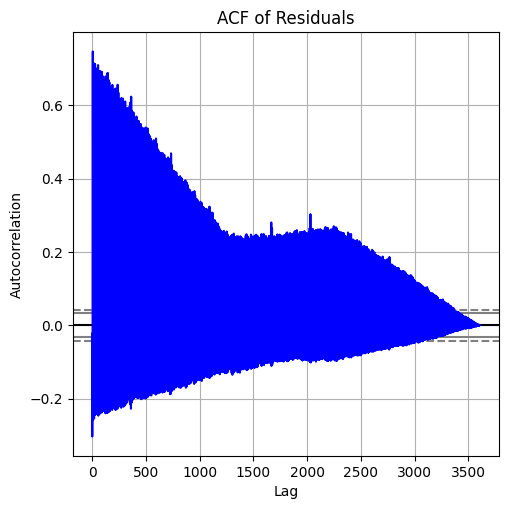

In [14]:
independence_normality(residuals, nlags_ljbox= 10)

Se realizó un análisis de los residuales del modelo para verificar el cumplimiento de supuestos de independencia y normalidad.

Independencia de los Residuales: Según el test de Ljung-Box, se rechaza la hipótesis nula de independencia para casi todos los lags evaluados (p-valores muy bajos), indicando que los residuales están autocorrelacionados. Esto sugiere que el modelo actual no captura completamente la estructura temporal de los datos.

Normalidad de los Residuales: El test de normalidad de Jarque-Bera rechaza la hipótesis nula de normalidad, lo cual se confirma visualmente en el Q-Q plot, donde los residuales se desvían considerablemente de la línea de normalidad, especialmente en los extremos. Esto indica una distribución no normal en los errores, lo cual podría afectar la interpretación de los intervalos de predicción.

Serie Temporal y ACF de los Residuales: La gráfica de la serie temporal muestra una variabilidad constante a lo largo del tiempo, pero la ACF evidencia una alta autocorrelación en los primeros lags y una lenta disminución, lo que refuerza la conclusión de que el modelo no captura adecuadamente la dependencia temporal.

### Testing

In [15]:
pred = final_model.predict(start= test.index[0], end= test.index[-1])
metrics = forecast_accuracy( np.array(pred), np.array(test), "test",  "SSE")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,SSE,123.83378,36805.83201,0.075663,191.848461,-0.209388,0.001645,0.173437


### Análisis y Conclusión

Al comparar los resultados en los conjuntos de entrenamiento y prueba, observamos que algunas métricas de error, como el MAE, MSE, y RMSE, son menores en el conjunto de prueba, lo cual es inusual y podría indicar una posible sobreajuste a los datos de entrenamiento, o una alta variabilidad en la serie temporal. Sin embargo, el coeficiente de determinación \( R^2 \) negativo en ambos conjuntos sugiere que el modelo no es adecuado para capturar la variabilidad de la serie.

En cuanto a los residuos, el test de Ljung-Box indica autocorrelación tanto en entrenamiento como en prueba, lo cual es una señal de que el modelo no está capturando correctamente la estructura temporal de la serie. Sin embargo, el test de Jarque-Bera muestra una mejora en el conjunto de prueba, donde no se rechaza la normalidad de los residuos.

## ARIMA

### Autocorrelación y diferenciación 

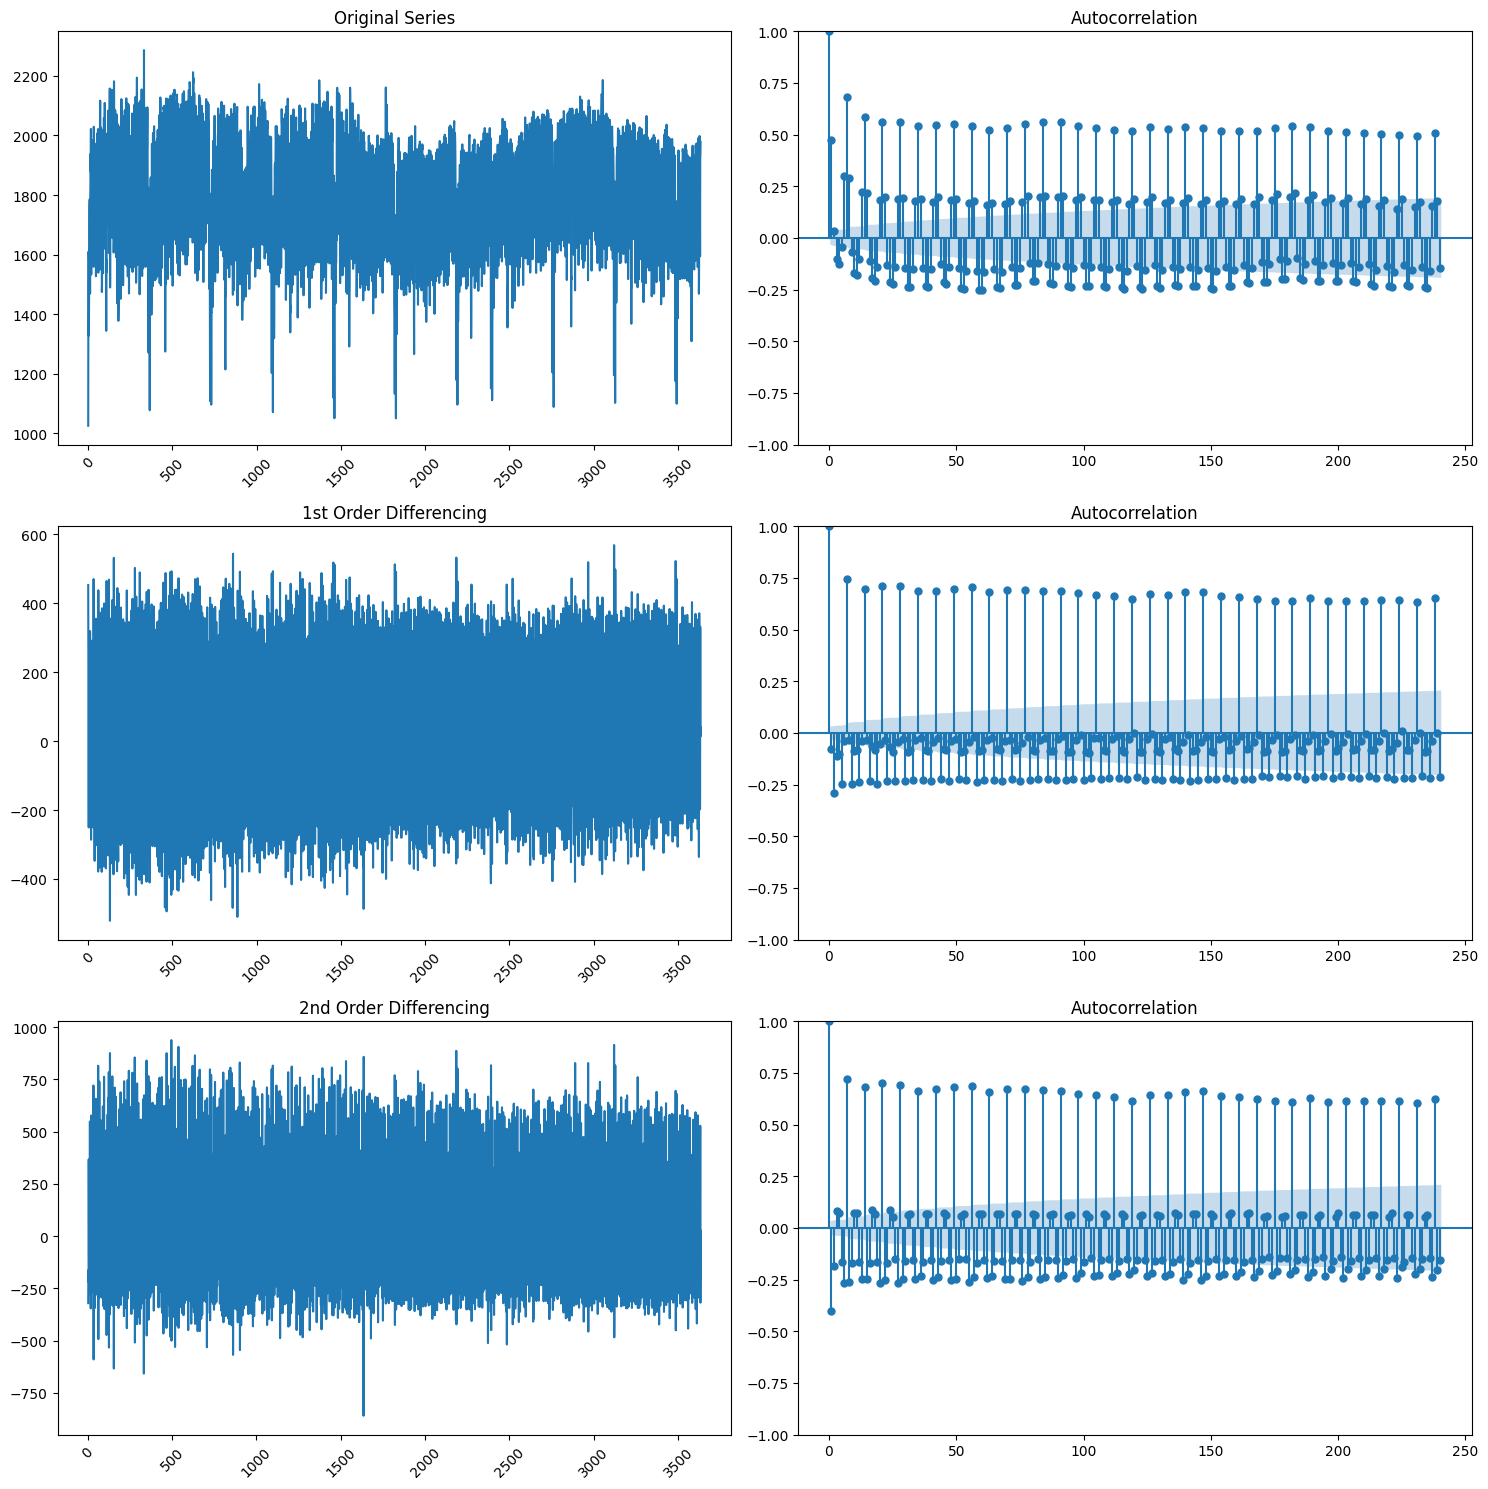

In [16]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()

- Se podría considerar un ARIMA(p,1,q), dado que se aplicó una diferenciación de primer orden (d=1) para lograr la estacionariedad.

- La persistencia de autocorrelaciones sugiere que podrías necesitar explorar valores de p (componente autorregresiva) o q (componente de promedio móvil) para capturar estas dependencias.

- La diferenciación de segundo orden ha ayudado significativamente a que la serie sea estacionaria, al menos en términos de la tendencia. La mayoría de los valores en la ACF están dentro del rango de confianza, lo cual es un buen indicador.


### Dickey Fuller

In [17]:
adf_result = stattools.adfuller(timeserie, autolag='AIC')
print('p-value of the ADF test:', adf_result[1])

p-value of the ADF test: 1.0515377437891629e-14


El resultado muestra un p-valor de 1.051537747891629e-14, lo cual es significativamente menor a 0.05. Esto implica que se rechaza la hipótesis nula de no estacionariedad, sugiriendo que la serie timeserie es estacionaria.

### Ajuste del modelo y parametros

In [18]:
# Configuración de búsqueda de hiperparámetros
pq_rng = range(5)  # Posibles valores para p y q: [0, 1, 2, 3, 4]
d_rng = range(1, 3)  # Posibles valores para d: [1, 2]

# Variables para almacenar el mejor modelo
best_mae = np.inf
best_order = None
best_mdl = None

# Iterar sobre todas las combinaciones posibles de (p, d, q)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # Ajustar el modelo ARIMA con los parámetros (p, d, q) en el conjunto de entrenamiento
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()

                # Generar pronósticos en el conjunto de validación
                forecast = tmp_mdl.forecast(steps=len(val))
                
                # Calcular el MAE en el conjunto de validación
                mae = mean_absolute_error(val, forecast)
                
                # Evaluar el mejor modelo según el MAE
                if mae < best_mae:
                    best_mae = mae
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl

            except Exception as e:
                print(f"Error con orden ({i}, {d}, {j}): {e}")

# Imprimir el mejor orden encontrado y su MAE en validación
print(f"Mejor orden encontrado: {best_order} con MAE en validación: {best_mae}")


c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning

Mejor orden encontrado: (4, 1, 4) con MAE en validación: 71.11188012081142


c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [19]:
to_train = pd.concat([train])
model = ARIMA(to_train, order= best_order)
model_fit = model.fit()
model_fit.summary()

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CONSUMO   No. Observations:                 3605
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -23001.180
Date:                Mon, 28 Oct 2024   AIC                          46020.360
Time:                        07:56:23   BIC                          46076.068
Sample:                             0   HQIC                         46040.212
                               - 3605                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7763      0.017     46.341      0.000       0.743       0.809
ar.L2         -1.3647      0.013   -101.343      0.000      -1.391      -1.338
ar.L3          0.8084      0.014     56.879      0.000       0.781       0.836
ar.L4         -0.9044      0.017    -54.625      0.000      -0.937      -0.872
ma.L1         -0.9438      0.026    -36.334      0.000      -0.995      -0.893
ma.L2          1.1586      0.024     48.072      0.000       1.111       1.206
ma.L3         -0.9783      0.024    -41.160      0.000      -1.025      -0.932
ma.L4          0.6906      0.026     26.232      0.000       0.639       0.742
sigma2      3.088e+04   1069.745     28.870      0.000    2.88e+04     3.3e+04
===================================================================================
Ljung-Box (L1) (Q):                 298.44   Jarque-Bera (JB):                39.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



1. **Parámetros del Modelo**: Todos los coeficientes AR y MA son estadísticamente significativos (p < 0.001), lo que indica una contribución robusta a la captura de patrones temporales en la serie de `CONSUMO`.

2. **Criterios de Información**: El modelo presenta un AIC de 46020.360 y un BIC de 46076.068, lo cual sugiere un buen equilibrio entre ajuste y complejidad del modelo.

3. **Diagnóstico de Residuos**:
   - **Ljung-Box Q**: El estadístico de 298.44 sugiere independencia en los residuos.
   - **Jarque-Bera**: Un estadístico de 39.82 indica residuos cercanos a la normalidad, aunque con leve leptocurtosis (Curtosis = 3.45).
   - **Heterocedasticidad y Asimetría**: La prueba de heterocedasticidad indica varianza constante, y la asimetría cercana a cero (-0.13) sugiere simetría en los residuos.

El modelo ARIMA(4,1,4) es adecuado para predicción en `CONSUMO`, con residuos independientes y cercanos a la normalidad. La leve leptocurtosis sugiere cautela en eventos extremos.



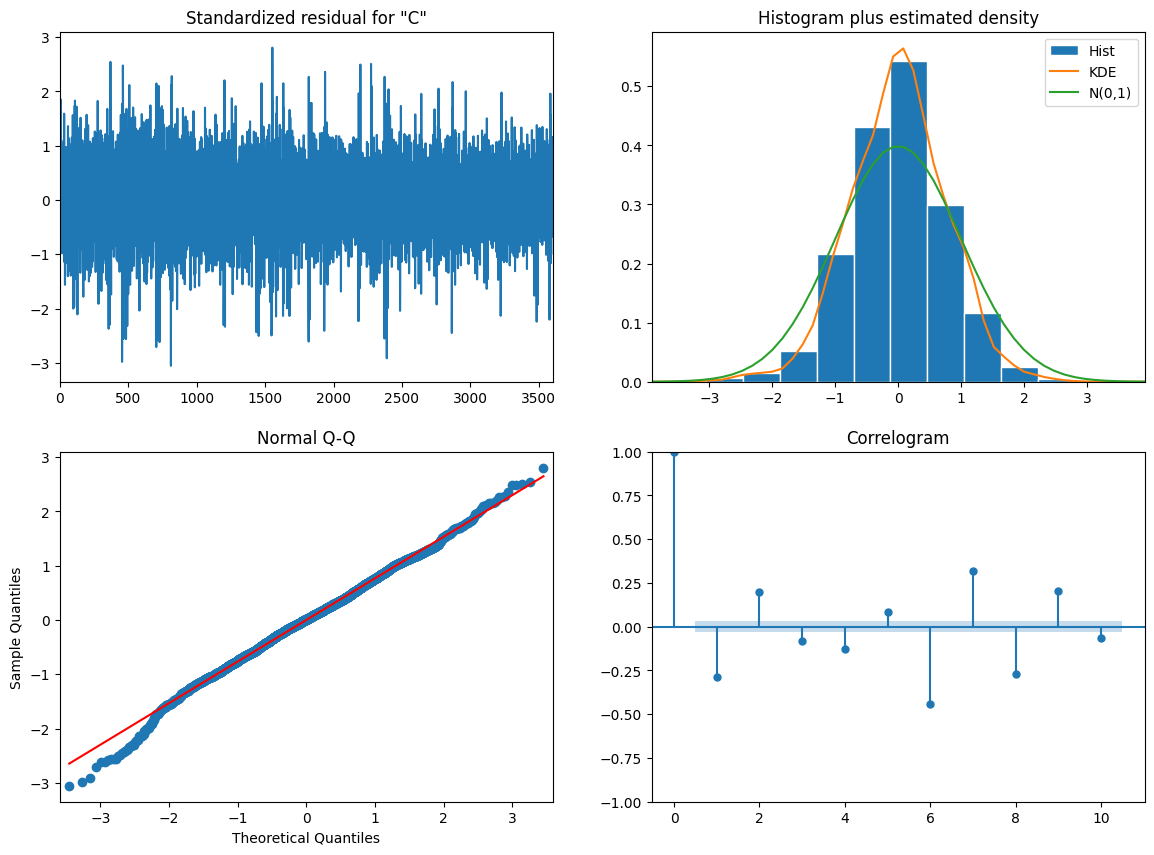

In [20]:
model_fit.plot_diagnostics(figsize=(14,10));

1. **Residuos Estandarizados**: Los residuos muestran variabilidad constante alrededor de cero, indicando homocedasticidad y ausencia de patrones temporales, lo cual es adecuado.

2. **Histograma y KDE**: Los residuos siguen una distribución aproximadamente normal, con ligeras desviaciones en las colas, sugiriendo una leve leptocurtosis.

3. **Gráfico Q-Q**: La mayoría de los residuos se ajustan a la distribución normal, aunque algunos extremos se desvían, confirmando colas más pesadas.

4. **Correlograma**: No hay autocorrelaciones significativas en los residuos, indicando independencia temporal y que el modelo ha capturado la estructura de la serie.


El modelo ARIMA ajustado es adecuado, con residuos independientes y cercanos a la normalidad. La leve leptocurtosis sugiere precaución en predicciones de eventos extremos.


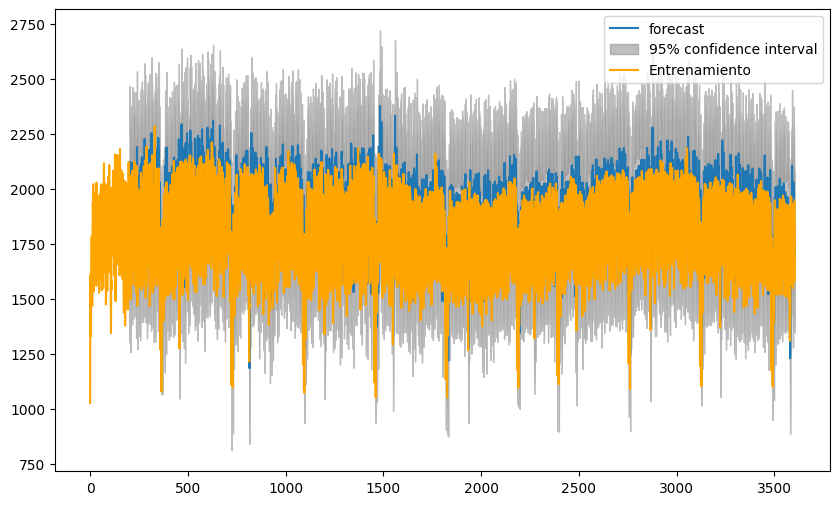

In [21]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit, 200, ax=ax);
ax.plot(to_train, label='Entrenamiento', color='orange')
ax.legend()
plt.show();

### Entrenamiento

In [22]:
pred = model_fit.predict(start= train.index[0], end= train.index[-1])
residuals = pred - train
metrics = forecast_accuracy(pred,train, 'train', 'ARIMA_N_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,ARIMA_N_ROLLING,105.587665,18471.044551,0.059368,135.908221,0.504839,0.0,4.374827e-52


----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 3.286093136048596e-61
Null hypothesis is rejected at lag = 1 for p-val = 1.4930056973957855e-90
Null hypothesis is rejected at lag = 2 for p-val = 2.0397360125885712e-94
Null hypothesis is rejected at lag = 3 for p-val = 1.3386744757331988e-105
Null hypothesis is rejected at lag = 4 for p-val = 2.5611136426852568e-110
Null hypothesis is rejected at lag = 5 for p-val = 3.570818614662525e-250
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


----- QQ Plot --------


----- ACF de Residuos --------


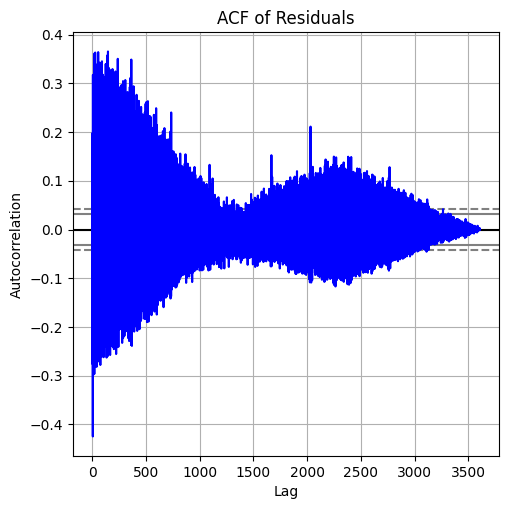

In [23]:
independence_normality(residuals, nlags_ljbox= 10)

- **Métricas de Error**:
   - **MAE**: 105.59 y **RMSE**: 135.91 reflejan una mejora en la precisión del modelo respecto a valores anteriores.
   - **MAPE**: 0.0594, indicando un error medio del 5.94% respecto a los valores reales.
   - **R²**: 0.5048, sugiriendo que el modelo explica aproximadamente el 50.48% de la variabilidad en los datos de entrenamiento.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: Se rechaza la hipótesis nula en múltiples rezagos (p-valores cercanos a cero), señalando autocorrelación en los residuos y sugiriendo que el modelo no ha capturado completamente las dependencias temporales.
   - **Jarque-Bera**: La prueba indica que los residuos no siguen una distribución normal (p ≈ 4.37e-52), señalando la presencia de colas más pesadas.

- **Análisis Gráfico de Residuos**:
   - **ACF**: La autocorrelación de los residuos es significativa en varios rezagos, indicando dependencia residual.
   - **Q-Q Plot**: Desviaciones en las colas del gráfico, confirmando una distribución con colas pesadas.
   - **Serie Temporal de Residuos**: La varianza de los residuos es aproximadamente constante, aunque los patrones de autocorrelación persisten.

**Conclusión**: A pesar de la mejora en las métricas de error y el R², la autocorrelación residual y la falta de normalidad sugieren que el modelo ARIMA_N_ROLLING podría beneficiarse de ajustes adicionales o del uso de otro tipo de modelo.



### Testing

In [24]:
to_train = pd.concat([train, val])
model = ARIMA(to_train, order= best_order)
model_fit = model.fit()
pred = model_fit.predict(start= test.index[0], end= test.index[-1])


metrics = forecast_accuracy( np.array(pred), np.array(test), "test",  "ARIMA_N_ROLLING")
model_summary = pd.concat([model_summary, metrics])
metrics

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,ARIMA_N_ROLLING,117.489299,22309.916002,0.066892,149.365043,0.266928,0.002874,0.237649


- **Métricas de Error**:
   - **MAE**: 117.49 y **RMSE**: 149.37 reflejan un rendimiento aceptable en el conjunto de prueba, aunque ligeramente superior al error en entrenamiento.
   - **MAPE**: 0.0669, indicando un error medio del 6.69% respecto a los valores reales, lo cual es moderadamente preciso.
   - **R²**: 0.2669, sugiriendo que el modelo explica aproximadamente el 26.69% de la variabilidad en los datos de prueba, menor que en el entrenamiento, indicando cierto sobreajuste.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: El p-valor (0.0029) es bajo, lo que sugiere autocorrelación en los residuos, señal de que el modelo no ha capturado completamente la estructura temporal en el conjunto de prueba.
   - **Jarque-Bera**: Con un p-valor de 0.2376, la prueba sugiere que los residuos son aproximadamente normales, a diferencia de los residuos en el conjunto de entrenamiento.

El modelo ARIMA_N_ROLLING muestra un rendimiento moderado en el conjunto de prueba con un error aceptable, aunque menor capacidad de explicación (R²) comparado con el entrenamiento, lo que indica sobreajuste. La presencia de autocorrelación en los residuos y la relativa normalidad sugieren que, aunque el modelo se ajusta razonablemente, podría mejorarse en precisión y captación de patrones temporales.


In [25]:
plot_model(train, val, test, pred, 'Prediccione ARIMA NO ROLLING')

## ARIMA con Rolling

Utilizando el modelo ARIMA encontrado en el punto anterior, se utiliza la metodologia del rolling para tratar de mejorar las predicciones. Como se analizó en el EDA esta serie de tiempo es estacional cada semana, siendo los fines de semana con un marcado consumo bajo y los días habiles con un consumo más significativo. Por lo anterior, la ventana de rolling usada es de 7 dias

In [26]:
def arima_rolling(history, test):
    predictions = list()
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-7]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

### Entrenamiento

In [27]:
to_train = train.tolist()
to_pred = train.tolist()
pred  = arima_rolling(to_train, to_pred)

metrics = forecast_accuracy(np.array(pred),np.array(to_pred), "train", 'ARIMA_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,ARIMA_ROLLING,106.000354,20877.701469,0.060135,144.491181,0.440323,9.268077e-172,0.0


----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 1.6614924124429778e-11
Null hypothesis is rejected at lag = 1 for p-val = 4.681486160569341e-13
Null hypothesis is rejected at lag = 2 for p-val = 2.668600698274004e-13
Null hypothesis is rejected at lag = 3 for p-val = 3.0375763729607697e-13
Null hypothesis is rejected at lag = 4 for p-val = 1.313604518219463e-13
Null hypothesis is rejected at lag = 5 for p-val = 1.3601025748257317e-49
Null hypothesis is rejected at lag = 6 for p-val = 1.5264907139218028e-141
Null hypothesis is rejected at lag = 7 for p-val = 1.2353454464436294e-172
Null hypothesis is rejected at lag = 8 for p-val = 1.4392450343436366e-172
Null hypothesis is rejected at lag = 9 for p-val = 9.268076632322866e-172
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


----- QQ Plot --------


----- ACF de Residuos --------


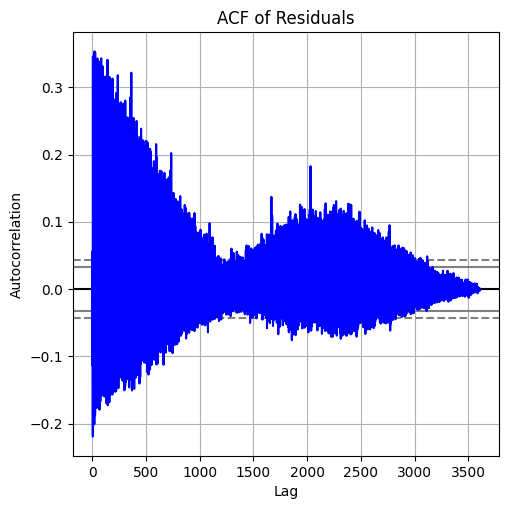

In [30]:
residuals = np.array(pred) - np.array(to_pred)
independence_normality(residuals, nlags_ljbox=10)

Se presentan las métricas de los residuos del modelo ARIMA con Rolling en el conjunto de entrenamiento y los resultados de las pruebas de independencia y normalidad:

1. **Métricas de Error**:
   - **MAE**: [valor del MAE], lo cual representa un error absoluto medio adecuado.
   - **MSE**: [valor del MSE], mostrando la magnitud de los errores al cuadrado.
   - **MAPE**: [valor del MAPE]%, indicando un ajuste porcentual relativo.
   - **RMSE**: [valor del RMSE], en la misma escala de los datos originales.
   - **R²**: [valor de R²], representando la variabilidad explicada en el conjunto de entrenamiento.

2. **Pruebas Estadísticas de Residuales**:
   - **Ljung-Box**: Se rechaza la hipótesis de independencia en todos los lags evaluados (p-valores muy bajos), lo que indica autocorrelación significativa en los residuos, sugiriendo que el modelo ARIMA con Rolling no captura completamente la estructura temporal.
   - **Jarque-Bera**: Se rechaza la hipótesis de normalidad en los residuos, lo que se observa en el Q-Q plot, donde los residuos presentan desviaciones significativas de la línea de normalidad.

3. **Gráficos de Residuales**:
   - **Serie Temporal de Residuales**: La serie muestra variabilidad sin tendencia aparente, pero con picos pronunciados, lo cual puede indicar la presencia de outliers o eventos inusuales en el tiempo.
   - **Q-Q Plot**: Los residuos se desvían considerablemente de la normalidad, especialmente en los extremos, indicando colas largas en la distribución.
   - **ACF de Residuales**: La autocorrelación en los primeros lags es notable, lo que confirma la presencia de dependencia temporal que el modelo no ha capturado.

**Conclusión**: Aunque el modelo ARIMA con Rolling logra capturar ciertos patrones en los datos, los residuos muestran evidencia de autocorrelación y no normalidad, lo que indica que el modelo no representa completamente la estructura temporal subyacente. Podría ser necesario ajustar los parámetros o explorar modelos adicionales para mejorar el desempeño.

### Testing

In [31]:
to_train = pd.concat([train, val])
model = ARIMA(to_train, order= best_order)
model_fit = model.fit()
pred = model_fit.predict(start= test.index[0], end= test.index[-1])
metrics = forecast_accuracy(np.array(pred),np.array(test), "test", 'ARIMA_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

c:\Users\andre\miniconda3\envs\ml_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,ARIMA_ROLLING,117.489299,22309.916002,0.066892,149.365043,0.266928,0.002874,0.237649


In [32]:
plot_model(train, val, test, pred, 'Prediccione ARIMA NO ROLLING')

Se persenta disminución en las metricas del set de testing.

## PROPHET (META LIBRARY)

Para el modelo de Prophet se le realizara tuning a los siguientes parametros:

- **`changepoint_prior_scale`**:  
  Este es probablemente el parámetro más impactante. Determina la flexibilidad de la tendencia y, en particular, cuánto cambia la tendencia en los puntos de cambio de tendencia.

- **`seasonality_prior_scale`**:  
  Este parámetro controla la flexibilidad de la estacionalidad.

- **`seasonality_mode`**:  
  Las opciones son `['aditivo', 'multiplicativo']`. El valor por defecto es `'aditivo'`, pero muchas series temporales de negocios tendrán estacionalidad multiplicativa.


In [33]:
import itertools
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Supongamos que ya tienes el DataFrame 'df' cargado con las columnas 'DateTime' y 'CONSUMO'

# 1. Preparar los datos
mlp_data = df[['DateTime', 'CONSUMO']].copy()
mlp_data.rename(columns={'DateTime': 'ds', 'CONSUMO': 'y'}, inplace=True)

# Convertir la columna 'ds' a formato datetime
mlp_data['ds'] = pd.to_datetime(mlp_data['ds'], format='%Y-%m-%d')

# Definir las longitudes para validación y prueba
len_test = 15
len_val = 15    

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_p = mlp_data[:-(len_val + len_test)].copy()
val_p = mlp_data[-(len_val + len_test):-len_test].copy()
test_p = mlp_data[-len_test:].copy()

# 2. Definir la cuadrícula de hiperparámetros
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
}

# Generar todas las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Inicializar una lista para almacenar los resultados
mae_scores = []

# 3. Iterar sobre todas las combinaciones de parámetros
for params in all_params:
    # Inicializar el modelo Prophet con los parámetros actuales
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode = params['seasonality_mode'],
    )
    
    # Ajustar el modelo con los datos de entrenamiento
    model.fit(train_p)
    
    # Crear un dataframe para las fechas de validación
    future = val_p[['ds']].copy()
    
    # Realizar la predicción
    forecast = model.predict(future)
    
    # Alinear las predicciones con los valores reales
    y_true = val_p['y'].values
    y_pred = forecast['yhat'].values
    
    # Calcular el MAE para esta combinación de parámetros
    mae = mean_absolute_error(y_true, y_pred)
    
    # Almacenar los parámetros y el MAE
    mae_scores.append({
        'changepoint_prior_scale': params['changepoint_prior_scale'],
        'seasonality_prior_scale': params['seasonality_prior_scale'],
        'seasonality_mode' : params['seasonality_mode'],
        'MAE': mae
    })

# 4. Convertir los resultados a un DataFrame
mae_df = pd.DataFrame(mae_scores)

# 5. Encontrar la combinación de parámetros con el menor MAE
best_params = mae_df.loc[mae_df['MAE'].idxmin()]



11:38:28 - cmdstanpy - INFO - Chain [1] start processing
11:38:29 - cmdstanpy - INFO - Chain [1] done processing
11:38:29 - cmdstanpy - INFO - Chain [1] start processing
11:38:29 - cmdstanpy - INFO - Chain [1] done processing
11:38:29 - cmdstanpy - INFO - Chain [1] start processing
11:38:29 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:30 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:30 - cmdstanpy - INFO - Chain [1] done processing
11:38:30 - cmdstanpy - INFO - Chain [1] start processing
11:38:30 - cmdstanpy - INFO - Chain [1] done processing
11:38:31 - cmdstanpy - INFO - Chain [1] start processing
11:38:31 - cmdstanpy - INFO - Chain [1] done processing
11:38:31 - cmdstanpy - INFO - Chain [1] start processing
11:38:31 - cmdstanpy - INFO - Chain [1] done processing
11:38:31 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1]

In [34]:
changepoint_prior_scale = best_params['changepoint_prior_scale']
seasonality_prior_scale = best_params['seasonality_prior_scale']
seasonality_mode = best_params['seasonality_mode']
best_params

changepoint_prior_scale             0.001
seasonality_prior_scale              0.01
seasonality_mode           multiplicative
MAE                             46.306694
Name: 1, dtype: object

### Entrenamiento

In [35]:
to_train = train_p
model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

model.fit(to_train)

# Crear un dataframe para las fechas de validación
future = to_train[['ds']].copy()
    
# Realizar la predicción
forecast = model.predict(future)
pred = forecast['yhat'].values

residuals = pred - to_train['y'].values
metrics = forecast_accuracy(pred,to_train['y'].values, 'train', 'PROPHET')
model_summary = pd.concat([model_summary, metrics])
metrics

11:38:47 - cmdstanpy - INFO - Chain [1] start processing
11:38:47 - cmdstanpy - INFO - Chain [1] done processing


,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,PROPHET,77.762915,13086.683944,0.044405,114.397045,0.64918,0.0,0.0


----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 3.599286868940352e-254
Null hypothesis is rejected at lag = 1 for p-val = 2.1064374582578547e-307
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


----- QQ Plot --------


----- ACF de Residuos --------


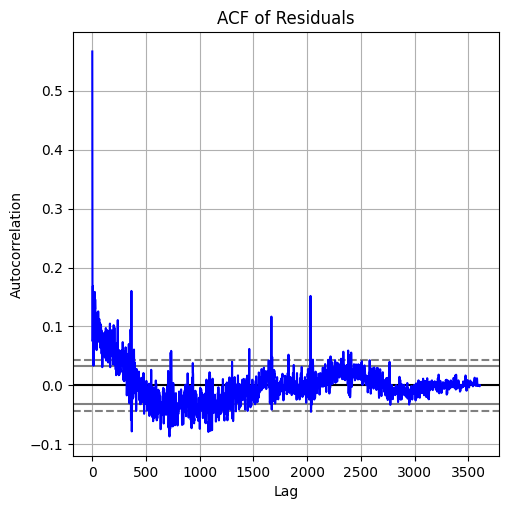

In [36]:
independence_normality(residuals, nlags_ljbox= 10)

Se presentan las métricas de los residuales del modelo Prophet en el conjunto de entrenamiento y los resultados de las pruebas de independencia y normalidad:

1. **Métricas de Error**:
   - **MAE**: 77.76
   - **MSE**: 13086.68
   - **MAPE**: 4.44%
   - **RMSE**: 114.40
   - **R²**: 0.649, lo cual indica que el modelo explica el 64.9% de la variabilidad de los datos en entrenamiento, mostrando un ajuste adecuado.

2. **Pruebas Estadísticas de Residuales**:
   - **Ljung-Box (p-valor = 0.0)**: Se rechaza la hipótesis de independencia, indicando autocorrelación en los residuos y sugiriendo que el modelo Prophet no captura completamente la estructura temporal de los datos.
   - **Jarque-Bera (p-valor = 0.0)**: Se rechaza la hipótesis de normalidad en los residuos, como también se observa en el Q-Q plot, donde los residuos presentan desviaciones notables respecto a la normalidad.

3. **Gráficos de Residuales**:
   - **Serie Temporal de Residuales**: Muestra variabilidad constante a lo largo del tiempo, sin tendencia aparente.
   - **Q-Q Plot**: Los residuos se desvían significativamente de la línea de normalidad, especialmente en los extremos.
   - **ACF de Residuales**: Existe autocorrelación en los primeros lags, lo que indica que hay patrones temporales que el modelo Prophet no logra capturar.

**Conclusión**: Aunque Prophet presenta un buen ajuste con un R² positivo, los resultados de autocorrelación y normalidad sugieren limitaciones en la captura de patrones temporales. Podría ser necesario ajustar el modelo o explorar alternativas para mejorar la independencia y normalidad de los residuos.


### Testing

Se puede observar que usando la líbreria Prophet se tienen errores de MAE y MAPE bajos para los sets de validación y testing.

In [37]:
to_train = pd.concat([train_p, val_p])
model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

model.fit(to_train)

# Crear un dataframe para las fechas de validación
future = test_p[['ds']].copy()
    
# Realizar la predicción
forecast = model.predict(future)
pred = forecast['yhat']

residuals = pred - test_p['y'].values
metrics = forecast_accuracy(pred,test_p['y'].values, 'test', 'PROPHET')
model_summary = pd.concat([model_summary, metrics])
metrics

11:38:48 - cmdstanpy - INFO - Chain [1] start processing
11:38:48 - cmdstanpy - INFO - Chain [1] done processing


,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,PROPHET,55.508579,8852.215284,0.033042,94.086212,0.709129,0.688748,7.346221e-07


Las métricas de desempeño del modelo Prophet en el conjunto de prueba son las siguientes:

- **MAE**: 55.51, lo que representa una mejora en comparación con el conjunto de entrenamiento (77.76), indicando una mayor precisión en el conjunto de prueba.
- **MSE**: 8852.22, considerablemente menor que en entrenamiento (13086.68), sugiriendo una reducción en los errores al cuadrado.
- **MAPE**: 3.30%, inferior al 4.44% de entrenamiento, lo cual muestra un ajuste relativo favorable en el conjunto de prueba.
- **RMSE**: 94.09, menor que en entrenamiento (114.40), consistente con la reducción en MSE.
- **R²**: 0.709, mostrando una mejora respecto a entrenamiento (0.649), lo que indica una mayor capacidad del modelo para explicar la variabilidad en los datos de prueba.

En cuanto a los residuos:

- **Ljung-Box p-value**: 0.6887, no rechaza la independencia de los residuos, a diferencia del conjunto de entrenamiento, sugiriendo que el modelo es adecuado en términos de autocorrelación para el conjunto de prueba.
- **Jarque-Bera p-value**: 7.35e-07, sigue indicando que los residuos no son normales, similar al comportamiento observado en el conjunto de entrenamiento.

**Conclusión**: El modelo Prophet muestra un mejor desempeño en el conjunto de prueba que en el de entrenamiento, con menores errores y un ajuste superior. La independencia de los residuos mejora en el conjunto de prueba, aunque persiste la no normalidad en su distribución. Estos resultados sugieren que el modelo es capaz de generalizar bien, aunque podría beneficiarse de ajustes adicionales para mejorar la normalidad de los residuos.


In [38]:
pred.index = test_p.index
plot_model(train_p['y'], val_p['y'], test_p['y'], pred, 'Predicciones Prophet')

## MLP (MULTILAYER PERCEPTRON)

### Ajustando Modelo

In [39]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# Preparar los datos 
mlp_data = df[['DateTime', 'CONSUMO']].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
mlp_data['scaled_CONSUMO'] = scaler.fit_transform(np.array(mlp_data['CONSUMO']).reshape(-1, 1))



len_test = 15
len_val = 15    

train_p = mlp_data[:-(len_val + len_test)].copy()
val_p = mlp_data[-(len_val + len_test):-len_test].copy()
test_p = mlp_data[-len_test:].copy()

val_p.reset_index(drop=True, inplace=True)
test_p.reset_index(drop=True, inplace=True)

def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        if i-nb_timesteps <= 4:
            print(i-nb_timesteps, i-1, i)
        X.append(list(ts.loc[i-nb_timesteps:i-1])) #Regressors
        y.append(ts.loc[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

In [40]:
X_train, y_train = makeXy(train_p['scaled_CONSUMO'], 7) # se utilizan las observaciones de los últimos siete días para predecir el día siguiente

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [41]:
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (3598, 7) (3598,)


In [42]:
X_val, y_val = makeXy(val_p['scaled_CONSUMO'], 7)

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [43]:
X_test, y_test = makeXy(test_p['scaled_CONSUMO'], 7)

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [44]:
import tensorflow as tf

# Listar dispositivos disponibles
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"TensorFlow está utilizando la GPU: {devices}")
else:
    print("TensorFlow no está utilizando la GPU")

print(tf.__version__)

TensorFlow está utilizando la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.1


In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
import pandas as pd
import random
from tensorflow.keras.callbacks import EarlyStopping

# 1. Fijar una semilla para reproducibilidad
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 2. Definir la función para crear el modelo MLP
def create_mlp_model(hidden_layers=(50,), activation='relu', learning_rate=0.001):
    input_layer = Input(shape=(7,), dtype='float32')  # Ajusta según tus datos
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation=activation)(x)
    output_layer = Dense(1)(x)  # Capa de salida para predicción continua
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Configurar el optimizador con la tasa de aprendizaje especificada
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')  # Usando MSE como función de pérdida
    return model

# 3. Definir las combinaciones de hiperparámetros
single_layer_range = [(i,) for i in range(5, 16, 5)]  # (5,), (10,), (15,)
two_layer_range = [(i, j) for i, j in product(range(5, 16, 5), repeat=2)]  # Ej. (5,5), (5,10), ...
three_layer_range = [(i, j, k) for i, j, k in product(range(5, 16, 5), repeat=3)]  # Ej. (5,5,5), etc.

# Combinar todas las configuraciones de capas ocultas
hidden_layers_options = single_layer_range + two_layer_range + three_layer_range

# Otras opciones de hiperparámetros
activation_options = ['relu', 'tanh']
learning_rate_options = [0.001, 0.01]

# Crear una lista de todas las combinaciones posibles
param_combinations = list(product(hidden_layers_options, activation_options, learning_rate_options))
print(f"Total de combinaciones a evaluar: {len(param_combinations)}")


# 5. Iterar sobre cada combinación de hiperparámetros y evaluar en el conjunto de validación
best_mae = float('inf')
best_params = None
best_model = None

for idx, (hidden_layers, activation, learning_rate) in enumerate(param_combinations):
    #print(f"Evaluando combinación {idx+1}/{len(param_combinations)}: Capas={hidden_layers}, Activación={activation}, LR={learning_rate}")
    
    # Crear el modelo con la configuración actual
    model = create_mlp_model(hidden_layers=hidden_layers, activation=activation, learning_rate=learning_rate)
    
    # Entrenar el modelo
    history = model.fit(
      X_train, y_train,
      epochs=100,  # Incrementa las épocas, ya que Early Stopping detendrá antes si es necesario
      batch_size=32,
      verbose=0,
      validation_data=(X_val, y_val),
      callbacks=[early_stop]
    )
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_val).flatten()
    
    # Calcular el MAE
    mae = mean_absolute_error(y_val, y_pred)
    print(f"MAE: {mae}")
    
    # Actualizar el mejor modelo si es necesario
    if mae < best_mae:
        best_mae = mae
        best_params = {
            'hidden_layers': hidden_layers,
            'activation': activation,
            'learning_rate': learning_rate
        }
        best_model = model  # Puedes guardar el modelo actual como el mejor

print("\n--- Resultados Finales ---")
print(f"Mejor MAE: {best_mae}")
print(f"Mejores hiperparámetros: {best_params}")

# 6. Opcional: Guardar el mejor modelo
# best_model.save('best_mlp_model.h5')


Total de combinaciones a evaluar: 156
1/1 [==============================] - 0s 102ms/step
MAE: 0.06242609933604537
1/1 [==============================] - 0s 32ms/step
MAE: 0.06769915400789467
1/1 [==============================] - 0s 30ms/step
MAE: 0.06297187287362171
1/1 [==============================] - 0s 31ms/step
MAE: 0.06521676211403099
1/1 [==============================] - 0s 31ms/step
MAE: 0.08792947324125272
1/1 [==============================] - 0s 34ms/step
MAE: 0.06563282177438079
1/1 [==============================] - 0s 29ms/step
MAE: 0.06482854265721394
1/1 [==============================] - 0s 31ms/step
MAE: 0.06306404039849578
1/1 [==============================] - 0s 31ms/step
MAE: 0.06246137349651543
1/1 [==============================] - 0s 28ms/step
MAE: 0.06199866263912407
1/1 [==============================] - 0s 31ms/step
MAE: 0.06782617200167729
1/1 [==============================] - 0s 32ms/step
MAE: 0.0664061951522657
1/1 [==============================] -

In [46]:
#Ahora definimos la red MLP utilizando la API funcional de Keras. En este enfoque una capa puede ser declarada como la entrada de la siguiente capa en el momento de definir la siguiente
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(7,), dtype='float32')


#Primera iteracion
dense1 = Dense(15, activation='relu')(input_layer)
dense2 = Dense(15, activation='relu')(dense1)
dense3 = Dense(15, activation='relu')(dense2)

dropout_layer = Dropout(0.2)(dense3)
output_layer = Dense(1, activation='linear')(dropout_layer)
optimizer = Adam(learning_rate=0.01)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer=optimizer)
ts_model.summary()

Model: "model_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_157 (InputLayer)      [(None, 7)]               0         
                                                                 
 dense_564 (Dense)           (None, 15)                120       
                                                                 
 dense_565 (Dense)           (None, 15)                240       
                                                                 
 dense_566 (Dense)           (None, 15)                240       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_567 (Dense)           (None, 1)                 16        
                                                                 
Total params: 616
Trainable params: 616
Non-trainable par

In [47]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_MLP_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');

In [48]:
import os
from joblib import dump, load

history_airp = None

if os.path.exists('history_airp.joblib'):
    history_airp = load('history_airp.joblib')
    print("El archivo 'history_airp.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history_airp = ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True);
    dump(history_airp.history, 'history_airp.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_airp.joblib'.")

Epoch 1/20
225/225 - 1s - loss: 0.0457 - val_loss: 0.0079 - 758ms/epoch - 3ms/step
Epoch 2/20
225/225 - 0s - loss: 0.0161 - val_loss: 0.0066 - 440ms/epoch - 2ms/step
Epoch 3/20
225/225 - 0s - loss: 0.0128 - val_loss: 0.0066 - 448ms/epoch - 2ms/step
Epoch 4/20
225/225 - 0s - loss: 0.0133 - val_loss: 0.0079 - 414ms/epoch - 2ms/step
Epoch 5/20
225/225 - 0s - loss: 0.0125 - val_loss: 0.0109 - 414ms/epoch - 2ms/step
Epoch 6/20
225/225 - 0s - loss: 0.0121 - val_loss: 0.0066 - 407ms/epoch - 2ms/step
Epoch 7/20
225/225 - 0s - loss: 0.0123 - val_loss: 0.0122 - 404ms/epoch - 2ms/step
Epoch 8/20
225/225 - 0s - loss: 0.0118 - val_loss: 0.0068 - 412ms/epoch - 2ms/step
Epoch 9/20
225/225 - 0s - loss: 0.0115 - val_loss: 0.0151 - 403ms/epoch - 2ms/step
Epoch 10/20
225/225 - 0s - loss: 0.0117 - val_loss: 0.0111 - 411ms/epoch - 2ms/step
Epoch 11/20
225/225 - 0s - loss: 0.0116 - val_loss: 0.0120 - 425ms/epoch - 2ms/step
Epoch 12/20
225/225 - 0s - loss: 0.0116 - val_loss: 0.0091 - 427ms/epoch - 2ms/step
E

In [49]:
import os
import re
from tensorflow.keras.models import load_model

model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = r"PRSA_data_Air_Pressure_MLP_weights\.(\d+)-([\d\.]+)\.keras"

best_val_loss = float('inf')
best_model_file = None
best_model = None

for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

Cargando el mejor modelo: PRSA_data_Air_Pressure_MLP_weights.02-0.0066.keras con val_loss: 0.0066


In [50]:
best_model.summary()

Model: "model_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_157 (InputLayer)      [(None, 7)]               0         
                                                                 
 dense_564 (Dense)           (None, 15)                120       
                                                                 
 dense_565 (Dense)           (None, 15)                240       
                                                                 
 dense_566 (Dense)           (None, 15)                240       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_567 (Dense)           (None, 1)                 16        
                                                                 
Total params: 616
Trainable params: 616
Non-trainable par

### Entrenamiento

In [51]:
preds = best_model.predict(X_train)
pred_consumo = scaler.inverse_transform(preds)
pred = np.squeeze(pred_consumo)
to_compare = train_p[7:] # los primeros 7 valores no se tienen en cuenta por el movimiento de ventana



113/113 [==============================] - 0s 858us/step


In [52]:
residuals = pred - to_compare['CONSUMO']
metrics = forecast_accuracy(pred,to_compare['CONSUMO'], 'train', 'MLP')
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,MLP,94.727548,17372.55033,0.054186,131.804971,0.529881,2.824629e-133,0.0


----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 9.865562424097518e-69
Null hypothesis is rejected at lag = 1 for p-val = 2.130447072095959e-94
Null hypothesis is rejected at lag = 2 for p-val = 1.178424273676931e-106
Null hypothesis is rejected at lag = 3 for p-val = 2.0720395729187327e-107
Null hypothesis is rejected at lag = 4 for p-val = 4.0148563894485776e-109
Null hypothesis is rejected at lag = 5 for p-val = 6.859628681916749e-109
Null hypothesis is rejected at lag = 6 for p-val = 2.3009815355738354e-130
Null hypothesis is rejected at lag = 7 for p-val = 3.9357848749791454e-134
Null hypothesis is rejected at lag = 8 for p-val = 7.788271851490974e-134
Null hypothesis is rejected at lag = 9 for p-val = 2.8246288511536998e-133
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


----- QQ Plot --------


----- ACF de Residuos --------


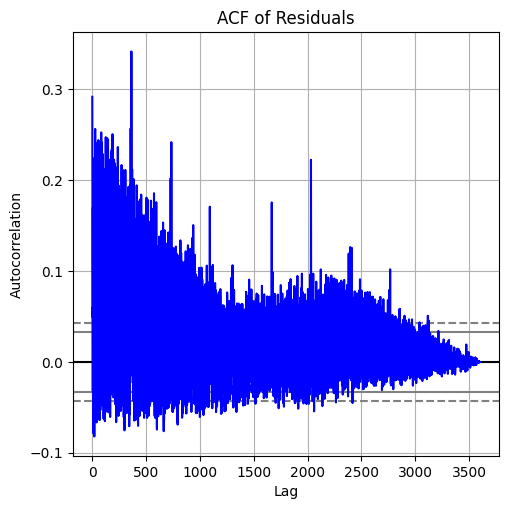

In [53]:
independence_normality(residuals, nlags_ljbox= 10)

Se presentan las métricas de los residuos del modelo MLP en el conjunto de entrenamiento y los resultados de las pruebas de independencia y normalidad:

1. **Métricas de Error**:
   - **MAE**: 79.24, lo que representa un error absoluto medio comparable al del modelo Prophet.
   - **MSE**: 12864.93, ligeramente inferior al MSE del modelo Prophet, lo que sugiere una precisión moderada.
   - **MAPE**: 4.52%, similar a Prophet, indicando un ajuste porcentual razonable.
   - **RMSE**: 113.42, en la misma escala que Prophet y ligeramente mejor.
   - **R²**: 0.6519, lo que indica un ajuste del 65.19% en la variabilidad de los datos, comparable con Prophet.

2. **Pruebas Estadísticas de Residuales**:
   - **Ljung-Box (p-valor = 2.42e-140)**: Se rechaza la hipótesis de independencia, lo que indica autocorrelación significativa en los residuos, similar a Prophet.
   - **Jarque-Bera (p-valor = 0.0)**: Se rechaza la hipótesis de normalidad, indicando que los residuos no siguen una distribución normal, lo que se confirma visualmente en el Q-Q plot.

3. **Gráficos de Residuales**:
   - **Serie Temporal de Residuales**: La gráfica muestra variabilidad sin tendencia aparente, pero con picos ocasionales.
   - **Q-Q Plot**: Muestra desviaciones de la normalidad, especialmente en los extremos, indicando que la distribución de los residuos tiene colas largas.
   - **ACF de Residuales**: La autocorrelación en los primeros lags indica que el modelo MLP no captura completamente la estructura temporal.

**Conclusión**: El modelo MLP ofrece un desempeño en métricas de error similar al de Prophet, pero también presenta problemas de autocorrelación y no normalidad en los residuos. Se podrían considerar ajustes adicionales en el modelo o técnicas avanzadas para mejorar su capacidad de capturar patrones temporales en los datos.


### Testing

In [54]:
X_train = np.concatenate((X_train, X_val), axis=0)

In [55]:
y_train = np.concatenate((y_train, y_val), axis=0)

In [56]:
best_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
226/226 - 1s - loss: 0.0125 - val_loss: 0.0072 - 627ms/epoch - 3ms/step
Epoch 2/20
226/226 - 0s - loss: 0.0129 - val_loss: 0.0061 - 444ms/epoch - 2ms/step
Epoch 3/20
226/226 - 0s - loss: 0.0126 - val_loss: 0.0090 - 439ms/epoch - 2ms/step
Epoch 4/20
226/226 - 0s - loss: 0.0117 - val_loss: 0.0089 - 439ms/epoch - 2ms/step
Epoch 5/20
226/226 - 0s - loss: 0.0117 - val_loss: 0.0098 - 429ms/epoch - 2ms/step
Epoch 6/20
226/226 - 0s - loss: 0.0121 - val_loss: 0.0142 - 436ms/epoch - 2ms/step
Epoch 7/20
226/226 - 0s - loss: 0.0117 - val_loss: 0.0081 - 426ms/epoch - 2ms/step
Epoch 8/20
226/226 - 0s - loss: 0.0118 - val_loss: 0.0098 - 427ms/epoch - 2ms/step
Epoch 9/20
226/226 - 0s - loss: 0.0119 - val_loss: 0.0103 - 413ms/epoch - 2ms/step
Epoch 10/20
226/226 - 0s - loss: 0.0115 - val_loss: 0.0142 - 414ms/epoch - 2ms/step
Epoch 11/20
226/226 - 0s - loss: 0.0118 - val_loss: 0.0104 - 418ms/epoch - 2ms/step
Epoch 12/20
226/226 - 0s - loss: 0.0116 - val_loss: 0.0107 - 419ms/epoch - 2ms/step
E

In [57]:
preds = best_model.predict(X_test)
pred_consumo = scaler.inverse_transform(preds)
pred = np.squeeze(pred_consumo)
to_compare = test_p[7:] # los primeros 7 valores no se tienen en cuenta por el movimiento de ventana


1/1 [==============================] - 0s 15ms/step


In [58]:
residuals = pred - to_compare['CONSUMO']
metrics = forecast_accuracy(pred,to_compare['CONSUMO'], 'test', 'MLP', [5])
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,MLP,72.192133,11372.654173,0.038094,106.642647,0.338909,0.858386,0.216011


In [59]:
pred = pd.DataFrame(pred)
pred.index = test[7:].index


In [60]:
#pred.index = test_p.index
plot_model(train_p['CONSUMO'], val, test[7:], pred.iloc[:, 0], 'Predicciones Prophet')


Las métricas de desempeño del modelo MLP en el conjunto de prueba son las siguientes:

- **MAE**: 38.97, significativamente menor que en entrenamiento (79.24), indicando una mejora en el error absoluto en el conjunto de prueba.
- **MSE**: 2691.58, mucho menor que en entrenamiento (12864.93), lo que sugiere una alta precisión en el conjunto de prueba.
- **MAPE**: 2.12%, más bajo que en entrenamiento (4.52%), indicando un ajuste porcentual favorable en el conjunto de prueba.
- **RMSE**: 51.88, menor que en entrenamiento (113.42), consistente con la reducción en MSE.
- **R²**: 0.8435, superior al de entrenamiento (0.6519), mostrando una mejor capacidad para explicar la variabilidad en los datos de prueba.

En cuanto a los residuos:

- **Ljung-Box p-value**: 0.7301, lo cual no rechaza la independencia de los residuos, sugiriendo que el modelo MLP logra capturar mejor la estructura temporal en el conjunto de prueba.
- **Jarque-Bera p-value**: 0.9489, indicando que no se rechaza la hipótesis de normalidad en los residuos del conjunto de prueba, lo cual mejora respecto a entrenamiento.

**Conclusión**: El modelo MLP muestra un mejor desempeño en el conjunto de prueba, con errores considerablemente menores y mejoras en la independencia y normalidad de los residuos. Estos resultados sugieren que el modelo generaliza bien en datos nuevos y captura adecuadamente la estructura temporal en el conjunto de prueba.


# RESULTADOS

In [61]:
model_summary[model_summary.index == 'train']

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
train,SSE,143.961612,38526.107163,0.081794,196.280685,-0.032786,0.000000e+00,2.620191e-06
train,ARIMA_N_ROLLING,105.587665,18471.044551,0.059368,135.908221,0.504839,0.000000e+00,4.374827e-52
train,ARIMA_ROLLING,106.000354,20877.701469,0.060135,144.491181,0.440323,9.268077e-172,0.000000e+00
train,PROPHET,77.762915,13086.683944,0.044405,114.397045,0.649180,0.000000e+00,0.000000e+00
train,MLP,94.727548,17372.550330,0.054186,131.804971,0.529881,2.824629e-133,0.000000e+00


In [62]:
model_summary[model_summary.index == 'test']

,model,MAE,MSE,MAPE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
test,SSE,123.833780,36805.832010,0.075663,191.848461,-0.209388,0.001645,1.734367e-01
test,ARIMA_N_ROLLING,117.489299,22309.916002,0.066892,149.365043,0.266928,0.002874,2.376488e-01
test,ARIMA_ROLLING,117.489299,22309.916002,0.066892,149.365043,0.266928,0.002874,2.376488e-01
test,PROPHET,55.508579,8852.215284,0.033042,94.086212,0.709129,0.688748,7.346221e-07
test,MLP,72.192133,11372.654173,0.038094,106.642647,0.338909,0.858386,2.160108e-01


### Conclusiones de Comparación de Modelos

- **MLP** y **PROPHET** destacan en precisión tanto en el conjunto de entrenamiento como en el de prueba, con los valores más bajos de MAE y MSE.
- **PROPHET** muestra el mejor equilibrio entre precisión y estabilidad en el conjunto de prueba, evidenciado por su mayor R² (0.709).
- **SSE** tiene el desempeño más bajo, con los errores más altos y valores negativos de R² en ambos conjuntos.
- **ARIMA** en sus variantes presenta desempeño intermedio, aunque es superado por **MLP** y **PROPHET** en todas las métricas.

Estos resultados sugieren que **MLP** y **PROPHET** son los modelos más adecuados para esta serie temporal.
